In [1]:
print("strawberry")

import torch
import numpy as np
import torch.nn.functional as F

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import argparse

import torch.nn as nn
import torch
from torchmetrics import Metric

def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined
    
def dice_loss(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    # is empties
    locs = torch.sum(y_true, dim=(-2, -1)) == 0
    wheres = torch.where(locs)[0]
    #print(wheres.shape)
    # print(wheres)
    #print(combined)
    r = 0.5
    combined[wheres] *= r
    #print(combined)
    
    return torch.sum(combined) / ((y_true.shape[0] - wheres.shape[0]) + (wheres.shape[0] * r))

def dice_loss_old(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    return torch.mean(combined)

def construct_parser():
    parser = argparse.ArgumentParser(description = "train models")
    
    parser.add_argument('--ckpt_dir', default=None, type=str)
    return parser

def get_transforms(is_3D):
        transforms = [
            LabelSelect(label_id=1),
            RandomFlip(p=0.5, orientation="horizontal", seed=1307),
            # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5), seed=1307),
            # GaussianNoise(p=0.2, mean=0, sigma=0.2, seed=1307),
            # RandomAffine(p=0.2, shear=(.1,3.), seed=1307),
            # RandomAffine(p=0.2, degrees=5, seed=1307),
            #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.), seed=1307)


            RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.), seed=1307) # ssn
        ]
        if not is_3D:
            transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
            return PairedCompose(transforms)
        else:
            transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
            transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
            return PairedCompose(transforms)
        
def train_val_test_split(dataset, val_prop, test_prop, seed):
        # I think the sklearn version might be prefereable for determinism and things
        # but that involves fiddling with the dataset implementation I think....
        size = len(dataset)
        test_size = int(test_prop*size) 
        val_size = int(val_prop*size)
        train_size = size - val_size - test_size
        train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
        return train, val, test
    
class StandardLitModelWrapper(pl.LightningModule):
        def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                    optimizer_constructor=None, lr_scheduler_constructor=None):
            super().__init__()
            self.model = model
            self.loss = loss
            self.logging_metric_train = logging_metric()
            self.logging_metric_val = logging_metric()
            self.optim_params = optimizer_params
            self.lr_scheduler_params = lr_scheduler_params
            self.is_uq_model = False
            self.optimizer_constructor = optimizer_constructor
            self.lr_scheduler_constructor = lr_scheduler_constructor


        def forward(self, x, **kwargs):
            return self.model(x, **kwargs)

        def configure_optimizers(self):
            # optimizer and schedulers go in the configure optimizers hook
            if self.optimizer_constructor:
                optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
            else:
                optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)

            if self.lr_scheduler_constructor:
                lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
            else:
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)

            return [optimizer], [lr_scheduler]

        def training_step(self, batch, batch_idx):
            """
            lightning automates the training loop, 
            does epoch, back_tracking, optimizers and schedulers,
            and metric reduction.
            we just define how we want to process a single batch. 
            we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
            hook, and I presume we can add our own parameters also to functions?
            """

            if self.is_uq_model:
                self.model.set_applyfunc(True)

            X, y = batch
            y_hat = self(X)
            loss = self.loss(y_hat, y)

            # metrics 
            if self.logging_metric_train:
                self.logging_metric_train(y_hat, y)
                self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
            self.log("train_loss", loss)

            return loss

    #     def training_epoch_end(self, outs):
    #         self.log('train_metric_epoch', self.logging_metric_train.compute())

    #     def validation_epoch_end(self, outs):
    #         self.log('val_metric_epoch', self.logging_metric_val.compute())

        def validation_step(self, batch, batch_idx):
            """
            note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
            well yes I want to enable checkpointing but will deal with that later.
            also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
            I will need a custom eval thing to do my dropout estimation but can solve that later too.
            """
            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            val_loss = self.loss(y_hat, y)

            if self.logging_metric_val:
                self.logging_metric_val(y_hat, y)
                self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
            self.log("val_loss", val_loss)

        def test_step(self, batch, batch_idx):
            """
            we would need to directly call this function using the trainer
            """

            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            test_loss = self.loss(y_hat, y)
            self.log("test_loss", test_loss)

        def predict_step(self, batch, batch_idx):
            """
            just for making predictions as opposed to collecting metrics etc
            note to use this, we just call .predict(dataloader) and it then automates the look
            these functions are for a single batch. Nice.
            """
            X, y = batch
            pred = self(X)
            return pred


### functions for getting code from the evidential distribution. Nice.

def relu_evidence(logits):
    return torch.nn.functional.relu(logits)

def exp_evidence(logits):
    return logits.clamp(-10, 10).exp()

def softplus_evidence(logits):
    return torch.nn.functional.softplus(logits)


def get_S(evidence):
    # evidence is shape [b, c, <dims>], we want an S per pixel, so reduce on dim 1
    S = (evidence + 1.).sum(dim = 1).unsqueeze(1)
    return S

def get_bk(evidence, S):
    return evidence / S

def get_uncert(K, S):
    return K / S

def get_alpha(evidence):
    return evidence + 1.

def get_one_hot_target(K, target):
    one_hot = torch.zeros((target.shape[0], K, *target.shape[1:])).to(target.device)
    one_hot[:,0] = 1 - target
    one_hot[:,1] = target
    
    return one_hot

def get_mean_p_hat(alpha, S):
    return alpha / S

######
def digamma(values):
    return torch.digamma(values).clamp(-100,100)

def get_alpha_modified(alpha, one_hot_target):
    return one_hot_target + ((1 - one_hot_target) * alpha)

def xent_bayes_risk(alpha, S, one_hot_target):
    digamma_S = torch.digamma(S).expand(alpha.shape)
    digamma_alpha = torch.digamma(alpha)
    
    p_ij = one_hot_target * (digamma_S - digamma_alpha)
    per_pixel_loss =  torch.sum(p_ij, dim=1)
    
    return torch.sum(per_pixel_loss, dim=(-2,-1)).mean() # reduction = mean


def mse_bayes_risk(mean_p_hat, S, one_hot_target):
    l_err = torch.nn.functional.mse_loss(mean_p_hat, one_hot_target, reduction='none')
    
    l_var = mean_p_hat * (1.- mean_p_hat) / (S + 1.)
    
    return (l_err + l_var).sum(dim=(-2,-1)).mean()


def KL(alpha_modified):
    K = alpha_modified.shape[1]
    beta = torch.ones((1, *alpha_modified.shape[1:])).to(alpha_modified.device)
    sum_alpha = alpha_modified.sum(dim=1)
    sum_beta = beta.sum(dim=1)
    
    lnB = torch.lgamma(sum_alpha) - torch.lgamma(alpha_modified).sum(dim=1)
    lnB_uni = torch.lgamma(beta).sum(dim=1) - torch.lgamma(sum_beta)
    
    dg0 = torch.digamma(sum_alpha).unsqueeze(1)
    dg1 = torch.digamma(alpha_modified)
    
    diff = (alpha_modified - beta)
    v = (dg1 - dg0)
    
    # print(sum_alpha.shape)
    # print(sum_beta.shape)
    # print(diff.shape)
    # print(v.shape)
    
    rhs = torch.sum(diff * v, dim=1)
    
    kl = lnB + lnB_uni + rhs
    
    return torch.sum(kl, dim=(-2,-1)).mean()

strawberry


In [2]:
x = torch.randn(10,10).abs()

In [2]:
import torch.distributions as td

In [4]:
td.Dirichlet(x).sample()

tensor([[5.2634e-02, 3.4163e-03, 4.8428e-02, 5.8659e-05, 3.2306e-01, 2.8338e-03,
         1.7380e-05, 1.5095e-01, 3.4979e-01, 6.8810e-02],
        [1.2147e-01, 2.4373e-04, 8.9967e-02, 4.6176e-01, 4.5116e-02, 1.4094e-01,
         1.6640e-04, 1.0342e-03, 1.3928e-01, 2.0253e-05],
        [9.9236e-06, 1.4688e-02, 1.9183e-01, 4.2084e-03, 3.7942e-01, 7.3032e-02,
         3.5140e-02, 2.1237e-02, 5.5997e-05, 2.8039e-01],
        [1.5415e-30, 2.0373e-02, 1.4840e-09, 4.4629e-02, 3.7993e-01, 6.4948e-02,
         1.8056e-01, 2.0708e-05, 1.3802e-01, 1.7151e-01],
        [4.0928e-03, 6.0195e-06, 2.5549e-01, 5.0539e-02, 5.1337e-02, 2.1920e-01,
         2.7342e-01, 4.3812e-02, 8.1131e-02, 2.0977e-02],
        [1.0430e-01, 5.1035e-02, 7.9407e-03, 3.4489e-01, 3.1980e-02, 2.3624e-02,
         6.7550e-03, 4.7426e-05, 2.6791e-01, 1.6152e-01],
        [1.1894e-02, 9.4265e-02, 7.7947e-03, 2.2313e-01, 6.1256e-05, 1.0179e-02,
         2.1865e-01, 1.3059e-02, 2.9862e-03, 4.1799e-01],
        [6.0285e-07, 1.6834

In [3]:
def epistemic_uncert(K, S):
    return K / S

def aleotoric_uncert(alpha, S):
    lhs = torch.digamma(alpha + 1)
    rhs = torch.digamma(S + 1)
    
    frac = alpha / S
    
    return -torch.sum(frac * (lhs - rhs), dim=1)
    
    
def distributional_uncert(alpha, S):
    frac = alpha / S
    rhs = torch.log(frac) - torch.digamma(alpha + 1) + torch.digamma(S + 1)
    return -torch.sum(frac * rhs, dim=1)

In [4]:
torch.manual_seed(1307)

In [5]:
ckpt_dir = "nana"
is3D = False
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

test_proportion = 0.1
validation_proportion = 0.2
seed = 3407

# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

print(len(train_dataset), len(val_dataset), len(test_dataset))

8743 2497 1248


In [7]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=1)

In [8]:
# collect the 2D x, y for the first batch only
xs = []
ys = []
for x, y in val_dataloader:
    xs.append(x)
    ys.append(y)
    break

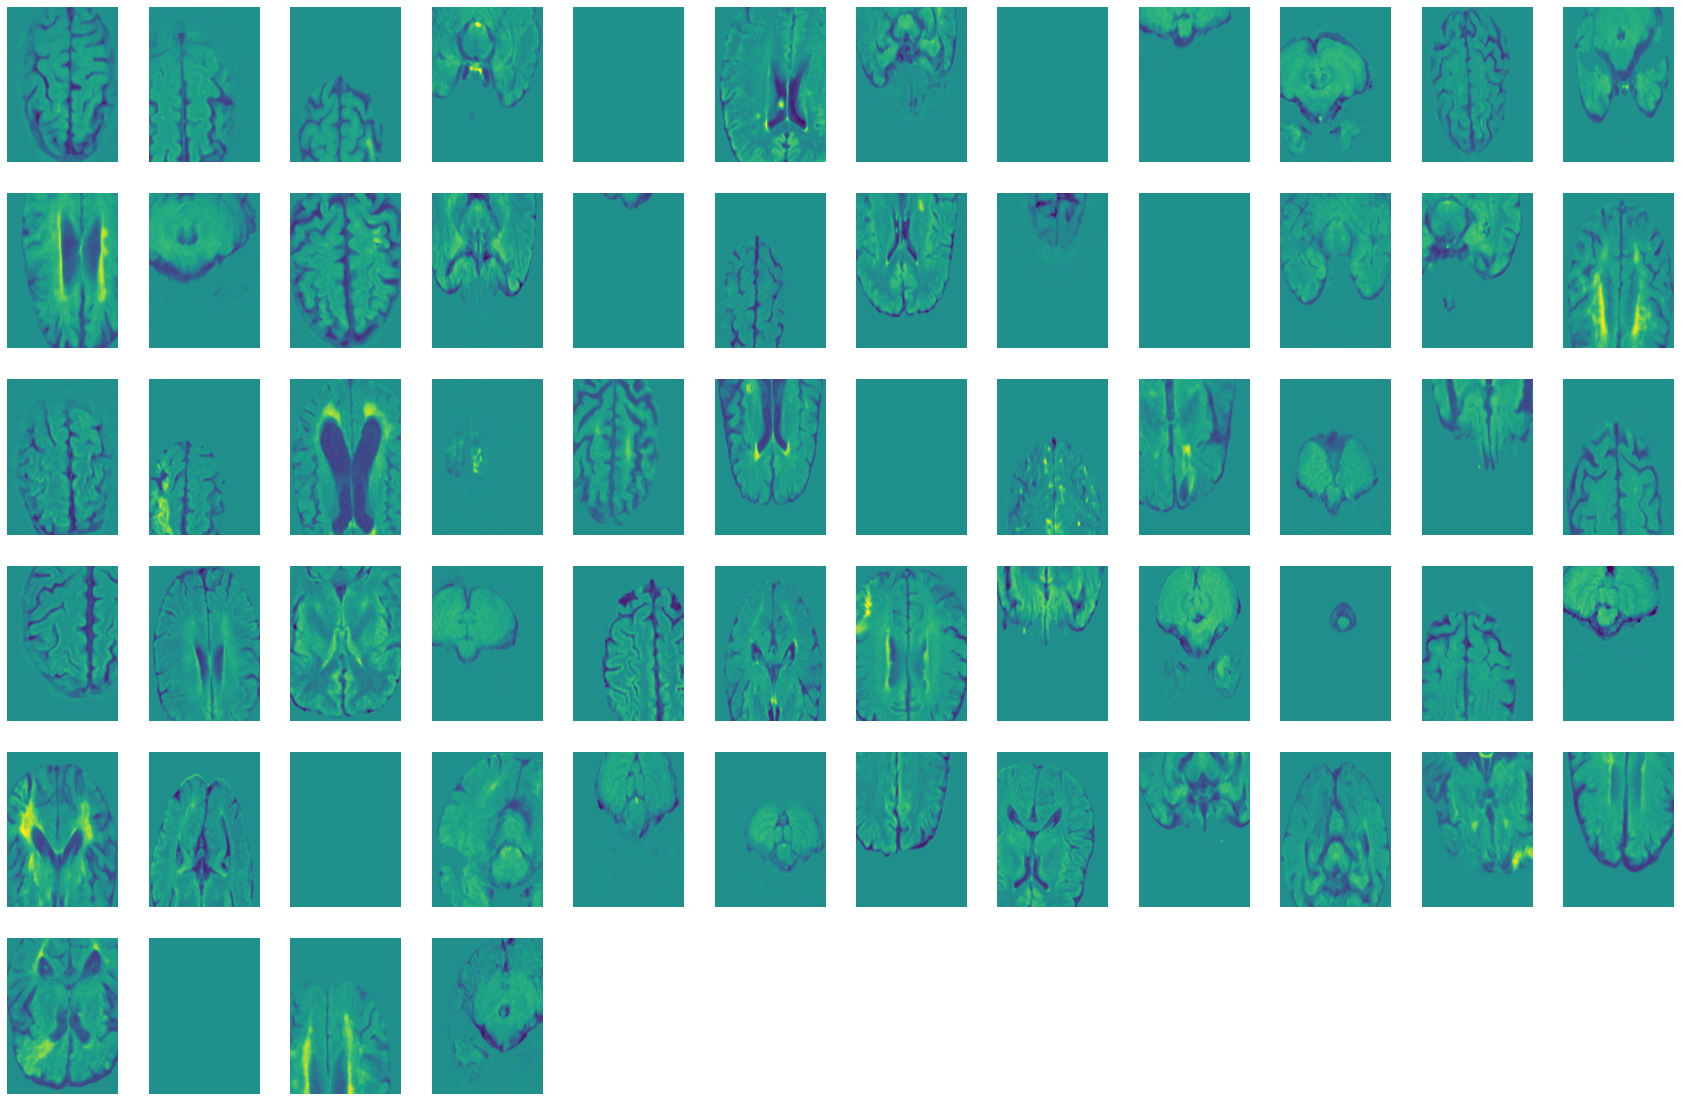

In [10]:
plt.figure(figsize=(30,20))
for i in range(64):
    plt.subplot(6, 12, i+1)
    plt.imshow(xs[0][i][0], vmin=-4, vmax=4)
    plt.axis('off')

In [9]:
accelerator="gpu"
devices=1
max_epochs=100
precision = 32

rootdir = "/disk/scratch/s2208943/results/final_models/"
ckpt_dir = "nana"
final_dir = rootdir + ckpt_dir
checkpoint_callback = ModelCheckpoint(final_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=15, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    precision=precision,
    default_root_dir=final_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
model_raw = HyperMapp3r(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 })

loss = dice_loss

optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[50,80], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [11]:
def ndigit(n, x):
    s = str(x)
    ns = "0" * (n - len(s))
    return ns + s

In [12]:
ndigit(2, 1)

'01'

### Loading the dataset in 3D for analysis
now each sample from the 3D dataset we can treat as a batch, and is a single image sample. Note that each batch may not be the same size now.

In [15]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
# BIG NOTE
# during evaluating the modle, we set is_3d false here to avoid doing the z cropping (which can cause nans)
# and instead we run the whole brain scan through and it gives us a good prediction over all. Nice.
datasets_domains_3d = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]


# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains_3d]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

### generating the samples procedure, only do this once

In [16]:
from tqdm import tqdm

In [17]:
xs3d = []
ys3d = []
for x, y in val_dataset_3d:
    xs3d.append(x)
    ys3d.append(y)

In [13]:
dice_factor = 10
root = "/home/s2208943/ipdis/results/final_models/"
folder = f"evidential_hpt_{dice_factor}/"

In [14]:

def combined_loss(logits, target):
        # get relevent terms required for loss func
        evidence = softplus_evidence(logits)
        S = get_S(evidence)
        alpha = get_alpha(evidence)
        K = alpha.shape[1]
        one_hot = get_one_hot_target(K, target)
        mean_p_hat = get_mean_p_hat(alpha, S)
        alpha_modified = get_alpha_modified(alpha, one_hot)


        #mse = mse_bayes_risk(mean_p_hat, S, one_hot)
        xent = xent_bayes_risk(alpha, S, one_hot)
        kl = KL(alpha_modified)

        dice = dice_loss(mean_p_hat, target)

        # print(kl)
        # print(xent)
        # print(dice)
        # print("--")

        return xent*0.2 + kl * 0.2 + dice * dice_factor

In [15]:
ckpts = sorted([c for c in os.listdir(root+folder) if "epoch" in c])
c = ckpts[-1]

In [16]:
model = StandardLitModelWrapper.load_from_checkpoint(root + folder + c, model=model_raw, loss=combined_loss, 
                                logging_metric=DiceLossMetric)
model = model.cuda()

In [22]:
#1
#trainer.validate(model, val_dataloader)

In [23]:
#5
#trainer.validate(model, val_dataloader)

In [24]:
#10
#trainer.validate(model, val_dataloader)

In [25]:
#20
#trainer.validate(model, val_dataloader)

In [135]:
def gen_samples(xs3dQ, ys3dQ):
    samples3d = [[] for i in range(len(ys3dQ))]
    for i in tqdm(range(len(ys3dQ)), position=0, leave=True, ncols=150):
        with torch.no_grad():
            model.eval()
            logits = model(xs3dQ[i].swapaxes(0,1).cuda()).cpu()
            evidence = softplus_evidence(logits)
            S = get_S(evidence)
            alpha = get_alpha(evidence)
            K = alpha.shape[1]
            mean_p_hat = get_mean_p_hat(alpha, S)
            
            for j in range(20):
                samples3d[i].append(mean_p_hat)
                           
            
    samples3d = [torch.stack(ss) for ss in samples3d]
    return samples3d

In [125]:
def gen_alphas(xs3dQ, ys3dQ):
    alphas = []
    Ss = []
    for i in tqdm(range(len(ys3dQ)), position=0, leave=True, ncols=150):
        with torch.no_grad():
            model.eval()
            out = model(xs3dQ[i].swapaxes(0,1).cuda()).cpu()
            evidence = softplus_evidence(out)
            alpha = get_alpha(evidence)
            S = get_S(evidence)
            
            alphas.append(alpha)
            Ss.append(S)
            
    #samples3d = [torch.stack(ss) for ss in samples3d]
    return alphas, Ss

In [126]:
alphas, Ss = gen_alphas(xs3d, ys3d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.79it/s]


In [136]:
samples3d = gen_samples(xs3d, ys3d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 19.54it/s]


In [137]:
means3d = [torch.mean(samples3d[i], dim=0) for i in range(len(samples3d))]

In [138]:
samples3d[0].shape, means3d[0].shape

(torch.Size([20, 40, 2, 224, 160]), torch.Size([40, 2, 224, 160]))

In [139]:
len(samples3d)

49

In [140]:
len(samples3d), len(samples3d[0])

(49, 20)

### generating the 2D samples of the first batch only, for the pictures! (and compute computation time)

In [17]:
import timeit

In [18]:
samples2d_onebatch = []
start_time = timeit.default_timer()
with torch.no_grad():
    model.eval()
    out = model(xs[0].cuda()).cpu()
    evidence = softplus_evidence(out)
    alpha = get_alpha(evidence)
    dist = td.Dirichlet(alpha)

    sample = dist.sample((20,)).squeeze()
    samples2d_onebatch = sample
        
elapsed = timeit.default_timer() - start_time

In [45]:
with torch.no_grad():
    samples2d_onebatch = []
    model.eval()
    out = model(xs[0].cuda()).cpu()
    evidence = softplus_evidence(out)
    evidence = softplus_evidence(out)
    S = get_S(evidence)
    alpha = get_alpha(evidence)
    K = alpha.shape[1]
    mean_p_hat = get_mean_p_hat(alpha, S)

    for j in range(20):
        samples2d_onebatch.append(mean_p_hat)

In [46]:
print("elapsed time (s): ", elapsed)

elapsed time (s):  11.221739651169628


In [47]:
len(samples2d_onebatch)

20

### fixed compute section

In [49]:
model_name = "evidential"

In [147]:
#os.mkdir("results/" + model_name)

### Generating uncertainty maps for a batch


In [50]:
def entropy_map_from_samples(alpha, S):
    return aleotoric_uncert(alpha, S)

### Creating the entropy map for the 2D samples

In [51]:
samples2d = torch.stack(samples2d_onebatch, dim=0)

In [52]:
samples2d.shape

torch.Size([20, 64, 2, 224, 160])

In [53]:
ent2dbatch = entropy_map_from_samples(alpha, S)

In [54]:
ent2dbatch.shape

torch.Size([64, 224, 160])

In [55]:
def save(fname):
    plt.tight_layout()
    plt.savefig("results/"+model_name + "/" + fname, bbox_inches = "tight")


In [57]:
showpred = samples2d.mean(dim=0).argmax(dim=1)

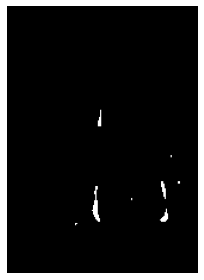

In [58]:
plt.imshow(showpred[5], cmap='gray');
plt.axis('off');
save("pred5")

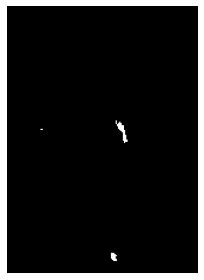

In [59]:
plt.imshow(showpred[20], cmap='gray');
plt.axis('off');
save("pred20")

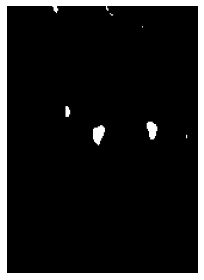

In [60]:
plt.imshow(showpred[58], cmap='gray');
plt.axis('off');
save("pred58")

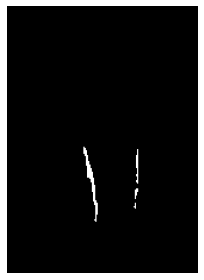

In [61]:
plt.imshow(showpred[37], cmap='gray');
plt.axis('off');
save("pred37")

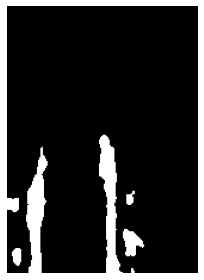

In [62]:
plt.imshow(showpred[62], cmap='gray');
plt.axis('off');
save("pred62")

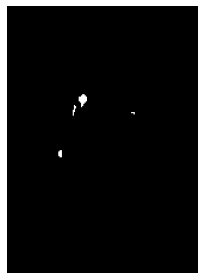

In [63]:
plt.imshow(showpred[49], cmap='gray');
plt.axis('off');
save("pred49")

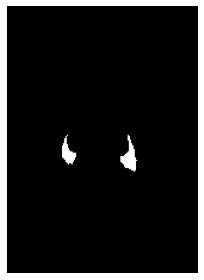

In [64]:
plt.imshow(showpred[50], cmap='gray');
plt.axis('off');
save("pred50")

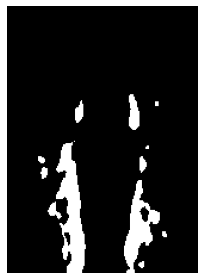

In [65]:
plt.imshow(showpred[23], cmap='gray');
plt.axis('off');
save("pred23")

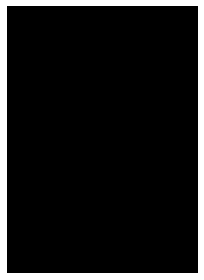

In [66]:
plt.imshow(showpred[30], cmap='gray');
plt.axis('off');
save("pred30")

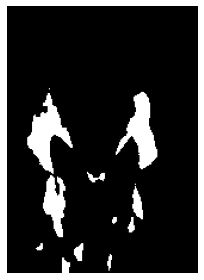

In [67]:
plt.imshow(showpred[48], cmap='gray');
plt.axis('off');
save("pred48")

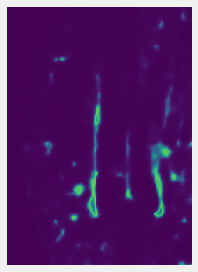

In [154]:
plt.imshow(ent2dbatch[5], vmin=0, vmax=0.7);
plt.axis('off');
save("img5")

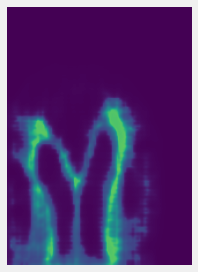

In [155]:
plt.imshow(ent2dbatch[20], vmin=0, vmax=0.7);
plt.axis('off');
save("img20")

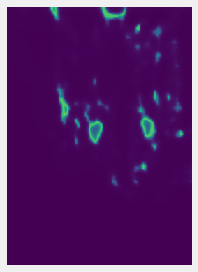

In [156]:
plt.imshow(ent2dbatch[58], vmin=0, vmax=0.7);
plt.axis('off');
save("img58")

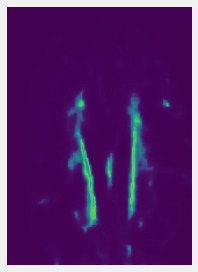

In [157]:
plt.imshow(ent2dbatch[37], vmin=0, vmax=0.7);
plt.axis('off');
save("img37")

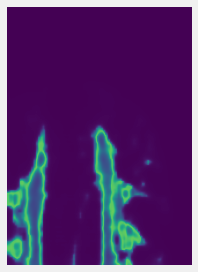

In [158]:
plt.imshow(ent2dbatch[62], vmin=0, vmax=0.7);
plt.axis('off');
save("img62")

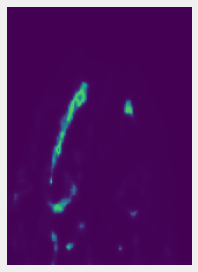

In [159]:
plt.imshow(ent2dbatch[49], vmin=0, vmax=0.7);
plt.axis('off');
save("img49")

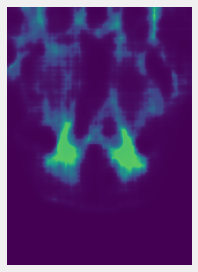

In [160]:
plt.imshow(ent2dbatch[50], vmin=0, vmax=0.7);
plt.axis('off');
save("img50")

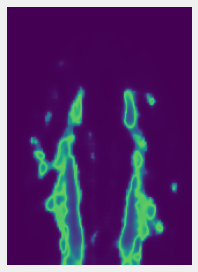

In [161]:
plt.imshow(ent2dbatch[23], vmin=0, vmax=0.7);
plt.axis('off');
save("img23")

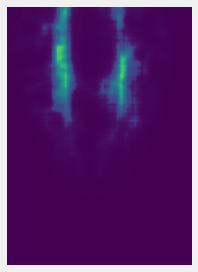

In [162]:
plt.imshow(ent2dbatch[30], vmin=0, vmax=0.7);
plt.axis('off');
save("img30")

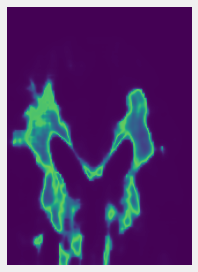

In [163]:
plt.imshow(ent2dbatch[48], vmin=0, vmax=0.7);
plt.axis('off');
save("img48")

In [164]:
# plt.figure(figsize=(30,20))
# ids = 5, 20, 58, 37, 62, 49, 50, 23, 30, 48
# count = 0
# for i in range(64):
#     if torch.sum(ys[0][i]) > 0:
#         plt.subplot(6, 12, count+1)
#         plt.imshow(ys[0][i], cmap='gray')
#         plt.title(i)
#         plt.axis('off')
#         plt.subplot(6, 12, count+2)
#         plt.imshow(ent2dbatch[i], vmin=0, vmax=0.7)
#         plt.title(i)
#         plt.axis('off')
#         count += 2

interesting images: 5, 20, 58, 37, 62, 49, 50, 23, 30, 48

### How do average dice and best dice improve with samples

In [165]:
len(samples3d), len(samples3d[0]), len(ys3d)

(49, 20, 49)

In [166]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    #print(y_pred.shape, y_true.shape)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [167]:
# compute the dice per sample, per individual
dices3d = []
for ind in tqdm(range(len(samples3d)), position=0, leave=True, ncols=150):
    sample_dices = []
    for s in range(len(samples3d[ind])):
        y_hat = samples3d[ind][s]
        y = ys3d[ind]
        sample_dices.append(dice(y_hat, y))
    dices3d.append(sample_dices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [04:04<00:00,  4.98s/it]


In [168]:
tensor_alldice3d = torch.stack([torch.Tensor(ds) for ds in dices3d], dim=0).swapaxes(0,1)

In [169]:
tensor_alldice3d.shape

torch.Size([20, 49])

In [170]:
# compute the mean and best dice as the number of samples increases from 1 to 20:
samples_vs_dices_mean = []
samples_vs_dices_best = []
for i in range(20):
    selected_samples_dices = tensor_alldice3d[0:i+1]
    mean_dice = torch.mean(selected_samples_dices, dim=0)
    best_dice = torch.max(selected_samples_dices, dim=0)[0]
    
    samples_vs_dices_mean.append(mean_dice.mean())
    samples_vs_dices_best.append(best_dice.mean())

In [171]:
mean_dice.mean(),mean_dice.std(), best_dice.mean(), best_dice.std()

(tensor(0.6642), tensor(0.1461), tensor(0.6642), tensor(0.1461))

In [172]:
samples_vs_dices_mean[0].shape

torch.Size([])

In [173]:
plt.style.use('fivethirtyeight')

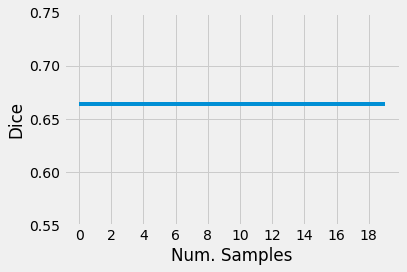

In [174]:
plt.plot(torch.arange(0, len(samples_vs_dices_mean), 1), samples_vs_dices_best)
plt.ylim(0.55, 0.75)
plt.xticks(torch.arange(0, 20, 2));
plt.xlabel("Num. Samples")
plt.ylabel("Dice");
save("samples_v_dice")

In [175]:
#print(torch.Tensor(samples_vs_dices_best))

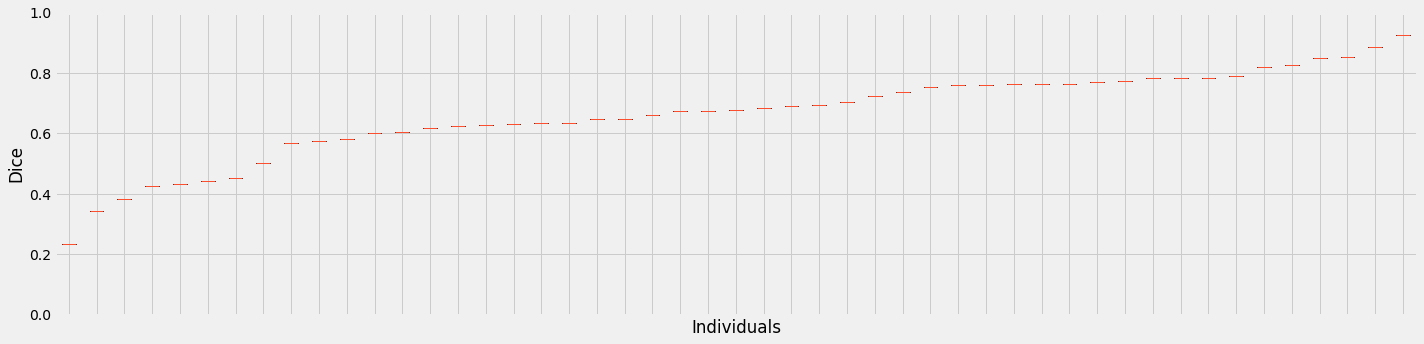

In [176]:
# sort in order of quality
order = torch.sort(torch.median(tensor_alldice3d, dim=0)[0])[1]
plt.figure(figsize=(20, 5))
plt.boxplot(tensor_alldice3d.T[order]);
plt.ylim(0, 1);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Dice")
plt.xlabel("Individuals")
save("sample_diversity")

### Calibration

In [177]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [178]:
def rolling_average(value, n, G):
    return value / n + ((n-1) / n) * G

def batch_rolling_average(values, n, G):
    """
    assumes all batches but the last batch are the same size
    """
    return values.sum() / (values.shape[0]*n) + ((n-1) / n) * G

In [179]:
len(samples3d)

49

In [180]:
# assess bin counts of p y = 1
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = ys3d[batch_idx]
    batch_samples = samples3d[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = batch_samples#torch.nn.functional.softmax(batch_samples, dim=2)
    p1s = probs[:,:,1]
    
    # split into bins
    bin_ids = place_in_bin(p1s)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        if num_elem == 0:
            print("zero")
        
        # number of predictions = to class 1
        c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem
        
        if torch.isnan(c1_acc):
            print("acc_nan")
        
        # average confidence of values in that bin
        c1_conf = p1s[is_in_bin].mean()
        
        if torch.isnan(c1_conf):
            print("conf_nan")
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)

 14%|████████████████▎                                                                                                 | 7/49 [00:19<01:54,  2.74s/it]

zero
acc_nan
conf_nan


 24%|███████████████████████████▋                                                                                     | 12/49 [00:34<02:00,  3.26s/it]

zero
acc_nan
conf_nan


 29%|████████████████████████████████▎                                                                                | 14/49 [00:42<02:04,  3.55s/it]

zero
acc_nan
conf_nan


 31%|██████████████████████████████████▌                                                                              | 15/49 [00:46<02:03,  3.62s/it]

zero
acc_nan
conf_nan


 35%|███████████████████████████████████████▏                                                                         | 17/49 [00:54<02:00,  3.77s/it]

zero
acc_nan
conf_nan


 45%|██████████████████████████████████████████████████▋                                                              | 22/49 [01:14<01:49,  4.05s/it]

zero
acc_nan
conf_nan


 47%|█████████████████████████████████████████████████████                                                            | 23/49 [01:18<01:43,  3.98s/it]

zero
acc_nan
conf_nan


 49%|███████████████████████████████████████████████████████▎                                                         | 24/49 [01:22<01:41,  4.06s/it]

zero
acc_nan
conf_nan


 59%|██████████████████████████████████████████████████████████████████▉                                              | 29/49 [01:44<01:30,  4.51s/it]

zero
acc_nan
conf_nan


 67%|████████████████████████████████████████████████████████████████████████████                                     | 33/49 [02:04<01:17,  4.85s/it]

zero
acc_nan
conf_nan


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 42/49 [02:49<00:34,  4.96s/it]

zero
acc_nan
conf_nan


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [03:24<00:00,  4.17s/it]


In [181]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]


In [182]:
bin_accuracies

[0.00030218716710805893,
 0.04498778283596039,
 0.13113270699977875,
 0.20833122730255127,
 0.29746392369270325,
 0.43587997555732727,
 0.5913046598434448,
 0.7263396382331848,
 0.8559730648994446,
 0.961456298828125,
 nan]

In [183]:
bin_confidences

[0.0008609600481577218,
 0.0877828374505043,
 0.19349145889282227,
 0.29737263917922974,
 0.4007556438446045,
 0.4983142018318176,
 0.5971691012382507,
 0.70060133934021,
 0.8039235472679138,
 0.9090621471405029,
 nan]

In [240]:
total_size = torch.sum(torch.Tensor(bin_sizes)[1:-1])
ece = torch.sum( (torch.Tensor(bin_sizes)[1:-1]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:-1] - torch.Tensor(bin_confidences)[1:-1])))
print("EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", ece)


EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0530)


In [185]:
"""
looking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing
and when optimizing calibration I should be optimizing this.
"""

'\nlooking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing\nand when optimizing calibration I should be optimizing this.\n'

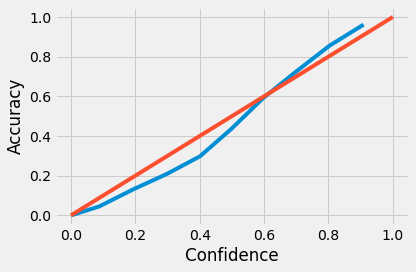

In [186]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);
plt.xlabel("Confidence")
plt.ylabel("Accuracy");
save("calibration")

In [187]:
#exd = batch_t.expand(p1s.shape)

In [188]:
# plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
# plt.yscale("log")

### Compute the PavPU metrics cause I'm not convinced my previous code in original ssn notebook was incorrect.

In [189]:
# I am going to do it per patch, but take the average accuracy per patch (perhaps I should qc average dice as well, best dice, worst dice.
uncetainty_thresholds = torch.arange(0, 0.7, 0.01)
accuracy_threshold = 0.9
window = 8
stride = 8
n_acs = [[] for i in range(len(uncetainty_thresholds))]
n_aus = [[] for i in range(len(uncetainty_thresholds))]
n_ics = [[] for i in range(len(uncetainty_thresholds))]
n_ius = [[] for i in range(len(uncetainty_thresholds))]

for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = ys3d[batch_idx]
    batch_samples = samples3d[batch_idx]
    ent = entropy_map_from_samples(alphas[batch_idx], Ss[batch_idx])
    
    # get probabilities
    probs = batch_samples#torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # get average accuracy of each sample
    # or I could treat each patch of each sample as a separate thing but that is not what I am doing here.
    avg_accuracy = ((batch_t.expand(pred_classes.shape) == pred_classes) * 1.).mean(dim=0)
    
    # unroll predictions and targets and entropy
    t_unrolled = batch_t.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    accuracy_unrolled = avg_accuracy.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    ent_unrolled = ent.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    
    accurate_patches = accuracy_unrolled > 0.9
    
    # for each uncertainty threshold, compute the 4 numbers
    for i, uncert_t in enumerate(uncetainty_thresholds):
        uncertain_patches = ent_unrolled > uncert_t
        
        n_acs[i].append(torch.sum(torch.logical_and(accurate_patches, ~uncertain_patches)))
        n_aus[i].append(torch.sum(torch.logical_and(accurate_patches, uncertain_patches)))
        n_ics[i].append(torch.sum(torch.logical_and(~accurate_patches, ~uncertain_patches)))
        n_ius[i].append(torch.sum(torch.logical_and(~accurate_patches, uncertain_patches)))
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [05:34<00:00,  6.83s/it]


In [190]:
n_acs_t = [torch.Tensor(n_acs[i]).sum() for i in range(len(uncetainty_thresholds))]
n_aus_t = [torch.Tensor(n_aus[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ics_t = [torch.Tensor(n_ics[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ius_t = [torch.Tensor(n_ius[i]).sum() for i in range(len(uncetainty_thresholds))]

In [191]:
p_acs = [n_acs_t[i] / (n_acs_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
p_aus = [n_ius_t[i] / (n_ius_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
pavpu = [(n_acs_t[i] + n_ius_t[i]) / (n_ius_t[i] + n_ics_t[i] + n_aus_t[i] + n_acs_t[i]) for i in range(len(uncetainty_thresholds))]

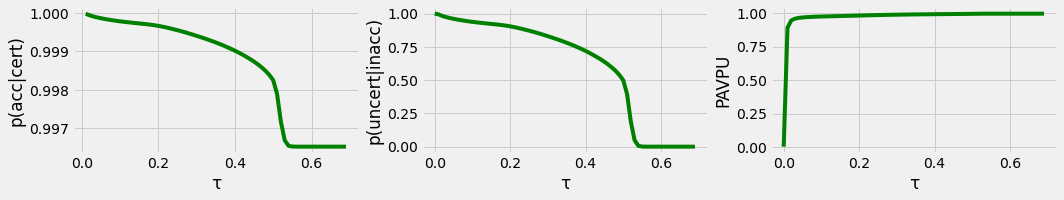

In [192]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(uncetainty_thresholds, p_acs, c='g')
plt.xlabel("τ")
plt.ylabel("p(acc|cert)")
plt.subplot(1,3,2)
plt.plot(uncetainty_thresholds, p_aus, c='g')
plt.ylabel("p(uncert|inacc)")
plt.xlabel("τ")
plt.subplot(1,3,3)
plt.plot(uncetainty_thresholds, pavpu, c='g')
plt.ylabel("PAVPU")
plt.xlabel("τ")
save("pavpu")


In [193]:
#uncetainty_thresholds

In [194]:
i=5
uncetainty_thresholds[i], p_acs[i], p_aus[i], pavpu[i]

(tensor(0.0500), tensor(0.9999), tensor(0.9615), tensor(0.9683))

In [195]:
#ent_thresh = uncetainty_thresholds[i]

In [196]:
ent_thresh = 0.05

### Quality Control in 3D - vcc corr-coeff

In [197]:
# generate entropy maps per individual
ind_ent_maps = [entropy_map_from_samples(alphas[batch_idx], Ss[batch_idx]) for i in range(len(ys3d))]

In [198]:
def VVC(v):
    #v = torch.nn.functional.softmax(v, dim=2)
    return torch.std(v) / torch.mean(v)

In [199]:
vvcs = [VVC(samples3d[i]) for i in range(len(ys3d))]

In [200]:
#vvcs_ent = [VVC(ind_ent_maps[i]) for i in range(len(ys3d))]

In [201]:
medians = torch.median(tensor_alldice3d, dim=0)[0]

In [202]:
print("correlation coefficient: ", torch.corrcoef(torch.stack([torch.Tensor(vvcs), medians]))[0][1])

correlation coefficient:  tensor(-0.7009)


In [203]:
#plt.scatter(vvcs, medians)

### TP FP TN FN distribution

In [204]:
all_tps = []
#all_tns = []
all_fps = []
all_fns = []

with torch.no_grad():
    for i in tqdm(range(len(ys3d)), position=0, leave=True, ncols=150):
        samples = samples3d[i]
        mean = means3d[i]
        ent = ind_ent_maps[i].view(-1)
        mean_class = mean.argmax(dim=1).view(-1)
        y = ys3d[i]
        x = xs3d[i].swapaxes(0,1)
        y_flat = y.view(-1)
        
        tp_loc = torch.where(torch.logical_and(y_flat == 1, mean_class == 1))[0]
        #tn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 0, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        fp_loc = torch.where(torch.logical_and(y_flat == 0, mean_class == 1))[0]
        fn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 1, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        # print(tp_loc.shape)
        # print(ent.view(-1).shape)
        
        all_tps.append(ent[tp_loc])
        #all_tns.append(ent[tn_loc])
        all_fps.append(ent[fp_loc])
        all_fns.append(ent[fn_loc])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:12<00:00,  3.86it/s]


In [205]:
tps = torch.cat(all_tps)
#tns = torch.cat(all_tns)
fps = torch.cat(all_fps)
fns = torch.cat(all_fns)

In [206]:
tps.shape, fps.shape, fns.shape

(torch.Size([551898]), torch.Size([117299]), torch.Size([187460]))

In [207]:
tps.mean(), fps.mean(), fns.mean()

(tensor(0.0493), tensor(0.0640), tensor(0.0478))

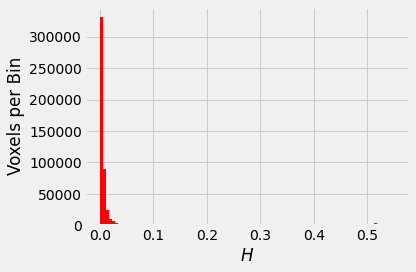

In [208]:
plt.hist(tps, bins=100, color='r');
plt.ylabel("Voxels per Bin")
#plt.ylim((0, 350000))
plt.xlabel("$H$")
save("tps")

In [209]:
print("test")

test


In [210]:
# plt.hist(fps, bins=100, color='r');
# plt.ylabel("Voxels per Bin")
# #plt.ylim((0, 50000))
# plt.xlabel("$H$")
# save("fps")

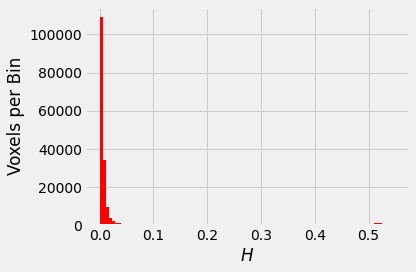

In [211]:
plt.hist(fns, bins=100, color='r');
plt.ylabel("Voxels per Bin")
#plt.ylim((0, 155000))
plt.xlabel("$H$")
save("fns")

In [212]:
import seaborn as sns

In [213]:
j = -1
ntps = len(tps)
nfns = len(fns)
nfps = len(fps)
selects = torch.arange(0, nfps, 100)
data = {"label":["TP" for _ in range(ntps)][0:j] + ["FN" for _ in range(nfns)][0:j] + ["FP" for _ in range(len(selects)+1)][0:j], "ent": torch.cat([tps[0:j], fns[0:j], fps[0:j][selects]]).numpy()}


In [214]:
len(data['label']), len(data['ent'])

(740529, 740529)

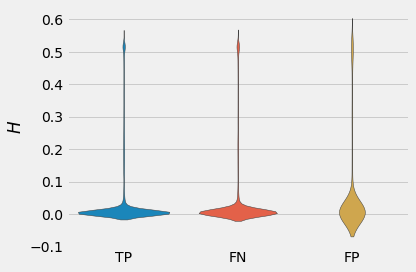

In [215]:
#plt.figure(figsize=(20, 5))
sns.violinplot(x="label", y="ent", data=data, linewidth=0.5, inner=None)
plt.ylabel("$H$")
save("types_violin")

### Missing lesions in 2D slices

In [216]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import kornia as K

def create_random_labels_map(classes: int) -> Dict[int, Tuple[int, int, int]]:
    labels_map: Dict[int, Tuple[int, int, int]] = {}
    for i in classes:
        labels_map[i] = torch.randint(0, 255, (3, ))
    labels_map[0] = torch.zeros(3)
    return labels_map

def labels_to_image(img_labels: torch.Tensor, labels_map: Dict[int, Tuple[int, int, int]]) -> torch.Tensor:
    """Function that given an image with labels ids and their pixels intrensity mapping, creates a RGB
    representation for visualisation purposes."""
    assert len(img_labels.shape) == 2, img_labels.shape
    H, W = img_labels.shape
    out = torch.empty(3, H, W, dtype=torch.uint8)
    for label_id, label_val in labels_map.items():
        mask = (img_labels == label_id)
        for i in range(3):
            out[i].masked_fill_(mask, label_val[i])
    return out

def show_components(img, labels):
    color_ids = torch.unique(labels)
    labels_map = create_random_labels_map(color_ids)
    labels_img = labels_to_image(labels, labels_map)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
    
    # Showing Original Image
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Orginal Image")
    
    #Showing Image after Component Labeling
    ax2.imshow(labels_img.permute(1,2,0).squeeze().numpy())
    ax2.axis('off')
    ax2.set_title("Component Labeling")

In [217]:
conncomp_outs = []

for y in tqdm(ys3d, position=0, leave=True, ncols=150):
    labels_out = K.contrib.connected_components(y.unsqueeze(1).type(torch.float32), num_iterations=150)
    conncomp_outs.append(labels_out)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:32<00:00,  1.88s/it]


In [218]:
missing_lesion_size_ent = []
existing_lesion_size_ent = []
proportion_missing_lesion_covered_ent = []
missing_lesion_size_mean = []
for batch in tqdm(range(len(ys3d)), position=0, leave=True, ncols=150):
    for i in range(0, ys3d[batch].shape[0], 3):
        conncomps = conncomp_outs[batch][i]
        ent = ind_ent_maps[batch][i]
        uncert = (ent > ent_thresh).type(torch.long)
        mean = means3d[batch].argmax(dim=1)[i]
        
        ids = conncomps.unique()[1:]
        for idx in ids:
            cc = (conncomps == idx)
            size = torch.sum(cc)
            if torch.max(uncert * cc) > 0:
                existing_lesion_size_ent.append(size)
            else:
                missing_lesion_size_ent.append(size)
                
            if torch.max(mean * cc) > 0:
                proportion_missing_lesion_covered_ent.append(torch.sum(uncert * cc) / size)
                missing_lesion_size_mean.append(size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [03:20<00:00,  4.10s/it]


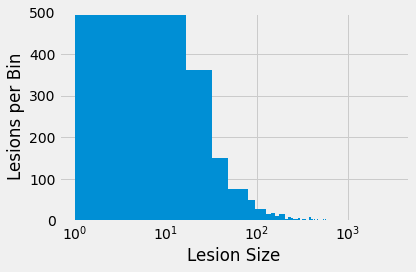

In [219]:
plt.hist(missing_lesion_size_ent, bins=200);
plt.xscale('log')
plt.ylim(0, 500)
plt.xlabel("Lesion Size")
plt.ylabel("Lesions per Bin")
save("missing_lesions")

In [220]:
print("means and stds of existing and missing lesions in 2D")
existing = torch.Tensor(existing_lesion_size_ent)
missing = torch.Tensor(missing_lesion_size_ent)
existing.mean(), existing.std(), missing.mean(), missing.std()

means and stds of existing and missing lesions in 2D


(tensor(211.3080), tensor(562.4823), tensor(45.8819), tensor(139.4874))

In [221]:
print("total number of lesions missing in 2D", len(missing_lesion_size_ent))

total number of lesions missing in 2D 2498


In [222]:
print("mean proportion of missing lesion covered by uncertainty: ", torch.Tensor(proportion_missing_lesion_covered_ent).mean())

mean proportion of missing lesion covered by uncertainty:  tensor(0.1389)


### How do uncertainty maps differ depending on the WMH damage values?

In [223]:
true_wmh_damage = []
lhss = []
rhss = []

for i in range(len(ys3d)):
    x = xs3d[i]
    y = ys3d[i]

    min_intensity = torch.min(x[0])
    norm_max_intensity = torch.max(x[0][y == 1]) - min_intensity
    nawm_range = (norm_max_intensity*0.5 + min_intensity, norm_max_intensity*0.75 + min_intensity)
    wmh_voxels = x[0][y==1]
    nawm_voxels = x[0][torch.logical_and(torch.logical_and(torch.logical_and(y==0, x[1] == 1), x[0] > nawm_range[0]), x[0] < nawm_range[1])]

    I_wmh = torch.mean(wmh_voxels)
    I_nawm = torch.mean(nawm_voxels)

    wmh_volume = wmh_voxels.shape[0]
    nawm_volume = nawm_voxels.shape[0]

    lhs = ((I_wmh - I_nawm) / I_nawm)
    rhs = (wmh_volume / (wmh_volume + nawm_volume))
    damage = lhs * rhs

    true_wmh_damage.append(damage)
    lhss.append(lhs)
    rhss.append(rhs)

    print("I_wmh: ", I_wmh, "I_nawm: ", I_nawm, "wmh volume: ", wmh_volume, "normal volume: ", nawm_volume, lhs, rhs, damage)


I_wmh:  tensor(1.4503) I_nawm:  tensor(0.9607) wmh volume:  3719 normal volume:  126492 tensor(0.5096) 0.02856133506385789 tensor(0.0146)
I_wmh:  tensor(1.5281) I_nawm:  tensor(0.8911) wmh volume:  7893 normal volume:  226215 tensor(0.7149) 0.03371520836536983 tensor(0.0241)
I_wmh:  tensor(1.5011) I_nawm:  tensor(0.7665) wmh volume:  5231 normal volume:  283864 tensor(0.9584) 0.018094398035247927 tensor(0.0173)
I_wmh:  tensor(1.7431) I_nawm:  tensor(0.9169) wmh volume:  8605 normal volume:  183037 tensor(0.9011) 0.044901430792832465 tensor(0.0405)
I_wmh:  tensor(1.7212) I_nawm:  tensor(0.6946) wmh volume:  11014 normal volume:  298507 tensor(1.4781) 0.035584015301061964 tensor(0.0526)
I_wmh:  tensor(1.5149) I_nawm:  tensor(0.7753) wmh volume:  7892 normal volume:  427757 tensor(0.9539) 0.018115501240677703 tensor(0.0173)
I_wmh:  tensor(1.4140) I_nawm:  tensor(0.6205) wmh volume:  5907 normal volume:  533367 tensor(1.2788) 0.01095361541628189 tensor(0.0140)
I_wmh:  tensor(1.7735) I_nawm

In [224]:
mean3ddice = tensor_alldice3d.mean(dim=0)

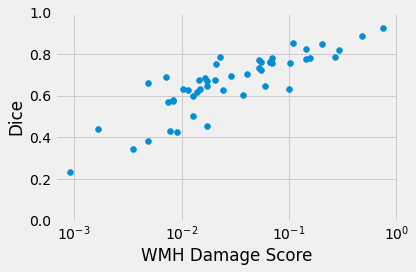

In [225]:
plt.scatter(true_wmh_damage, mean3ddice)
plt.xscale('log')
plt.ylim(0, 1)
plt.ylabel('Dice')
plt.xlabel('WMH Damage Score')
save("dice_v_damage")

In [226]:
ind_ent_sums = [torch.sum(e) for e in ind_ent_maps]

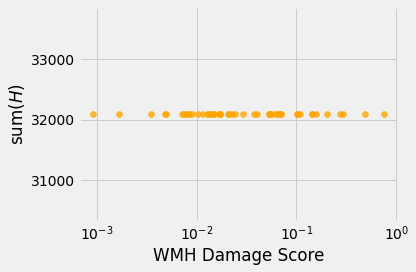

In [227]:
plt.scatter(true_wmh_damage, ind_ent_sums, alpha=0.8, c='orange')
plt.xscale('log')
plt.ylabel('sum($H$)')
plt.xlabel('WMH Damage Score')
save("ent_v_damage")

In [228]:
print("correlation coefficient: ", torch.corrcoef(torch.stack([torch.Tensor(ind_ent_sums), torch.log10(torch.Tensor(true_wmh_damage))]))[0][1])

correlation coefficient:  tensor(7.9480e-09)


### Domain Adaption

In [229]:
domains_all = [wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ]

In [230]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
datasets_domains_all = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains_all]


In [243]:
# assess bin counts of p y = 1
def ECE_domains(qys3d, qsamples3d):
    bins = 10 + 1 # for the 0 bin
    bin_batch_accuracies = [[] for b in range(bins)]
    bin_batch_confidences = [[] for b in range(bins)]
    bin_batch_sizes = [[] for b in range(bins)]
    bin_counts = [0 for b in range(bins)]
    for batch_idx in tqdm(range(0, len(qys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
        batch_t = qys3d[batch_idx]
        batch_samples = qsamples3d[batch_idx]

        if batch_t.shape[0] < 10:
            continue # skip last batch if it is very small.

        # get probabilities
        probs = batch_samples#torch.nn.functional.softmax(batch_samples, dim=2)
        p1s = probs[:,:,1]

        # split into bins
        bin_ids = place_in_bin(p1s)

        # compute counts
        for i in range(bins):
            is_in_bin = (bin_ids == (i / 10))
            # print(is_in_bin.shape)
            # print(batch_t.shape)

            # number of elements in each bin
            num_elem = torch.sum(is_in_bin).item()
            if num_elem == 0:
                print("zero")

            # number of predictions = to class 1
            c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem

            if torch.isnan(c1_acc):
                print("acc_nan")

            # average confidence of values in that bin
            c1_conf = p1s[is_in_bin].mean()

            if torch.isnan(c1_conf):
                print("conf_nan")

            bin_batch_accuracies[i].append(c1_acc)
            bin_batch_confidences[i].append(c1_conf)
            bin_batch_sizes[i].append(num_elem)

    bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
    bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
    bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]
    total_size = torch.sum(torch.Tensor(bin_sizes)[1:-1])
    
    #print(bin_accuracies)
    ece = torch.sum( (torch.Tensor(bin_sizes)[1:-1]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:-1] - torch.Tensor(bin_confidences)[1:-1])))
    print("EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", ece)

In [232]:
# compute the dice per sample, per individual
def dices_ind(qsamples, qys):
    qdices3d = []
    for ind in tqdm(range(0, len(qsamples)), position=0, leave=True, ncols=150):
        sample_dices = []
        for s in range(len(qsamples[ind])):
            y_hat = qsamples[ind][s]
            y = qys[ind]
            sample_dices.append(dice(y_hat, y))
        qdices3d.append(sample_dices)
        
    qtensor_alldice3d = torch.stack([torch.Tensor(ds) for ds in qdices3d], dim=0).swapaxes(0,1)
    qmean_dice = torch.mean(qtensor_alldice3d, dim=0)
    qbest_dice = torch.max(qtensor_alldice3d, dim=0)[0]
    
    return qmean_dice.mean(), qmean_dice.std(), qbest_dice.mean(), qbest_dice.std()




### domain 1

In [244]:
wxs3d = []
wys3d = []
for i in range(0, len(datasets_domains_all[0]), 3):
    x,y = datasets_domains_all[0][i]
    wxs3d.append(x)
    wys3d.append(y)

In [245]:
wsamples3d = gen_samples(wxs3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.95it/s]


In [249]:
ECE_domains(wys3d, wsamples3d)

 29%|████████████████████████████████▊                                                                                  | 2/7 [00:08<00:21,  4.35s/it]

zero
acc_nan
conf_nan


 57%|█████████████████████████████████████████████████████████████████▋                                                 | 4/7 [00:17<00:12,  4.33s/it]

zero
acc_nan
conf_nan


 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 5/7 [00:21<00:08,  4.32s/it]

zero
acc_nan
conf_nan


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6/7 [00:25<00:04,  4.32s/it]

zero
acc_nan
conf_nan


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:30<00:00,  4.32s/it]

zero
acc_nan
conf_nan
EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0252)


In [250]:
dices_ind(wsamples3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:33<00:00,  4.76s/it]


(tensor(0.6590), tensor(0.1627), tensor(0.6590), tensor(0.1627))

### doamain 2

In [251]:
wxs3d = []
wys3d = []
for i in range(0, len(datasets_domains_all[1]), 3):
    x,y = datasets_domains_all[0][i]
    wxs3d.append(x)
    wys3d.append(y)

In [252]:
wsamples3d = gen_samples(wxs3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.35it/s]


In [253]:
ECE_domains(wys3d, wsamples3d)

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 4/7 [00:17<00:13,  4.42s/it]

zero
acc_nan
conf_nan


 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 5/7 [00:22<00:08,  4.41s/it]

zero
acc_nan
conf_nan


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6/7 [00:26<00:04,  4.41s/it]

zero
acc_nan
conf_nan


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:30<00:00,  4.42s/it]

EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0547)


In [254]:
dices_ind(wsamples3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:33<00:00,  4.77s/it]


(tensor(0.6699), tensor(0.2017), tensor(0.6699), tensor(0.2017))

### domain 3

In [255]:
wxs3d = []
wys3d = []
for i in range(0, len(datasets_domains_all[2]), 3):
    x,y = datasets_domains_all[0][i]
    wxs3d.append(x)
    wys3d.append(y)

In [256]:
wsamples3d = gen_samples(wxs3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.73it/s]


In [257]:
ECE_domains(wys3d, wsamples3d)

 29%|████████████████████████████████▊                                                                                  | 2/7 [00:08<00:22,  4.42s/it]

zero
acc_nan
conf_nan


 57%|█████████████████████████████████████████████████████████████████▋                                                 | 4/7 [00:17<00:13,  4.46s/it]

zero
acc_nan
conf_nan


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6/7 [00:26<00:04,  4.45s/it]

zero
acc_nan
conf_nan


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:31<00:00,  4.45s/it]

zero
acc_nan
conf_nan
EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0821)


In [258]:
dices_ind(wsamples3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:33<00:00,  4.79s/it]


(tensor(0.6491), tensor(0.1994), tensor(0.6491), tensor(0.1994))